In [4]:
!python -V

Python 3.9.12


In [5]:
#In this notebook:
# 1 - we load and prepare data
# 2 - we vectorize categorical data
# 3 - we train model

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [7]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [8]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-experiment")

<Experiment: artifact_location='./mlruns/1', creation_time=1742848426446, experiment_id='1', last_update_time=1742848426446, lifecycle_stage='active', name='nyc-experiment', tags={}>

In [9]:
def read_dataframe(filename):
    #load file
    df = pd.read_parquet(filename)
    #convert column to datetime type
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    #convert column to datetime type
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    #creates column duration which is difference dropoff time - pickup time
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    #td == Timedelta. This converts it into seconds and / 60 making it minutes
    df.duration = df.duration.apply(lambda td:td.total_seconds() / 60)
    #Drop outliers by:
    #Filter dataframe and reassign to all rows that contain duration btw 1 min and 60 min
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    #assign variables for numerical and categorical data in dataset for further
    #one hotting categorical data
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    #categorical must be str objects in pandas
    df[categorical] = df[categorical].astype(str)
    return df

In [10]:
#assign train and validation datasets
df_train = read_dataframe('../data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('../data/green_tripdata_2021-02.parquet')

In [11]:
#check sizes of datasets
len(df_train), len(df_val)

(73908, 61921)

In [12]:
#engineer feature to concatenate PU and DO times in 1 column
df_train['PU_DO']= df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO']= df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [13]:

categorical = ['PU_DO']
numerical = ['trip_distance']
#dv will create one hot encoding for categorical data
dv = DictVectorizer()
#to make one hot dv needs data in dictionary format
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
#dv is a model itself so it needs to learn data
X_train = dv.fit_transform(train_dicts)
#validation set can be transformed without learning
val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [14]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.479562160810692

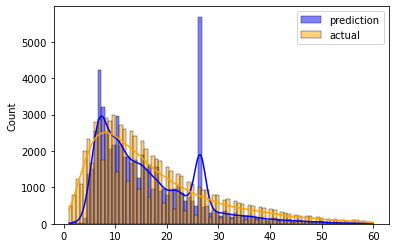

In [16]:
sns.histplot(y_pred, label='prediction', kde=True, color='blue')
sns.histplot(y_train, label='actual', kde=True, color='orange')
plt.legend()  # Show labels
plt.show()

In [17]:
#save model and datavectorizer to preserve training data
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [18]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "Vlad")
    
    mlflow.log_param('train-data-path','../data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path','../data/green_tripdata_2021-02.parquet')

    
    alpha = 0.1
    mlflow.log_param("alpha",alpha)
    
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric('rmse', rmse)

In [19]:
import xgboost as xgb


In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [21]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [22]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=20,
            evals=[(valid, 'validation')],
            early_stopping_rounds=5
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [23]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

[0]	validation-rmse:9.72283                                                                                                  
  0%|                                                                                 | 0/50 [00:00<?, ?trial/s, best loss=?]

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.32292                                                                                                  
[2]	validation-rmse:7.58260                                                                                                  
[3]	validation-rmse:7.19072                                                                                                  
[4]	validation-rmse:6.98766                                                                                                  
[5]	validation-rmse:6.87828                                                                                                  
[6]	validation-rmse:6.82156                                                                                                  
[7]	validation-rmse:6.78615                                                                                                  
[8]	validation-rmse:6.76104                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:36] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.60592                                                                                                 
[1]	validation-rmse:9.43289                                                                                                  
[2]	validation-rmse:8.58976                                                                                                  
[3]	validation-rmse:7.99655                                                                                                  
[4]	validation-rmse:7.58342                                                                                                  
[5]	validation-rmse:7.29782                                                                                                  
[6]	validation-rmse:7.09960                                                                                                  
[7]	validation-rmse:6.96299                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.41321                                                                                                  
[1]	validation-rmse:7.17193                                                                                                  
[2]	validation-rmse:6.79246                                                                                                  
[3]	validation-rmse:6.66043                                                                                                  
[4]	validation-rmse:6.60051                                                                                                  
[5]	validation-rmse:6.57217                                                                                                  
[6]	validation-rmse:6.55516                                                                                                  
[7]	validation-rmse:6.54353                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.68109                                                                                                 
[1]	validation-rmse:11.19368                                                                                                 
[2]	validation-rmse:10.74797                                                                                                 
[3]	validation-rmse:10.34129                                                                                                 
[4]	validation-rmse:9.97077                                                                                                  
[5]	validation-rmse:9.63313                                                                                                  
[6]	validation-rmse:9.32687                                                                                                  
[7]	validation-rmse:9.04925                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:20:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.29658                                                                                                  
[1]	validation-rmse:7.83853                                                                                                  
[2]	validation-rmse:7.15287                                                                                                  
[3]	validation-rmse:6.83384                                                                                                  
[4]	validation-rmse:6.67713                                                                                                  
[5]	validation-rmse:6.59661                                                                                                  
[6]	validation-rmse:6.55059                                                                                                  
[7]	validation-rmse:6.52596                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:20:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.33589                                                                                                  
[1]	validation-rmse:6.76557                                                                                                  
[2]	validation-rmse:6.67294                                                                                                  
[3]	validation-rmse:6.65112                                                                                                  
[4]	validation-rmse:6.63693                                                                                                  
[5]	validation-rmse:6.62295                                                                                                  
[6]	validation-rmse:6.61495                                                                                                  
[7]	validation-rmse:6.60855                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:20:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77404                                                                                                 
[1]	validation-rmse:11.36499                                                                                                 
[2]	validation-rmse:10.98416                                                                                                 
[3]	validation-rmse:10.62967                                                                                                 
[4]	validation-rmse:10.30124                                                                                                 
[5]	validation-rmse:9.99554                                                                                                  
[6]	validation-rmse:9.71322                                                                                                  
[7]	validation-rmse:9.45160                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04719                                                                                                  
[1]	validation-rmse:6.99514                                                                                                  
[2]	validation-rmse:6.72363                                                                                                  
[3]	validation-rmse:6.65021                                                                                                  
[4]	validation-rmse:6.61908                                                                                                  
[5]	validation-rmse:6.61010                                                                                                  
[6]	validation-rmse:6.60044                                                                                                  
[7]	validation-rmse:6.59276                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[3]	validation-rmse:10.78616                                                                                                 
[4]	validation-rmse:10.48740                                                                                                 
[5]	validation-rmse:10.20891                                                                                                 
[6]	validation-rmse:9.95043                                                                                                  
[7]	validation-rmse:9.71045                                                                                                  
[8]	validation-rmse:9.48817                                                                                                  
[9]	validation-rmse:9.28143                                                                                                  
[10]	validation-rmse:9.09095                                                                                          

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:22:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38347                                                                                                 
[1]	validation-rmse:10.66748                                                                                                 
[2]	validation-rmse:10.05275                                                                                                 
[3]	validation-rmse:9.52720                                                                                                  
[4]	validation-rmse:9.07972                                                                                                  
[5]	validation-rmse:8.70043                                                                                                  
[6]	validation-rmse:8.38020                                                                                                  
[7]	validation-rmse:8.11102                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:23:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.29027                                                                                                 
[1]	validation-rmse:8.99901                                                                                                  
[2]	validation-rmse:8.14410                                                                                                  
[3]	validation-rmse:7.58377                                                                                                  
[4]	validation-rmse:7.23060                                                                                                  
[5]	validation-rmse:7.00463                                                                                                  
[6]	validation-rmse:6.86042                                                                                                  
[7]	validation-rmse:6.76593                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:23:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53625                                                                                                 
[1]	validation-rmse:10.93233                                                                                                 
[2]	validation-rmse:10.39468                                                                                                 
[3]	validation-rmse:9.91810                                                                                                  
[4]	validation-rmse:9.49607                                                                                                  
[5]	validation-rmse:9.12347                                                                                                  
[6]	validation-rmse:8.79430                                                                                                  
[7]	validation-rmse:8.50802                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:24:05] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86529                                                                                                  
[1]	validation-rmse:7.45500                                                                                                  
[2]	validation-rmse:6.90142                                                                                                  
[3]	validation-rmse:6.68131                                                                                                  
[4]	validation-rmse:6.58169                                                                                                  
[5]	validation-rmse:6.53372                                                                                                  
[6]	validation-rmse:6.50581                                                                                                  
[7]	validation-rmse:6.49029                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:24:16] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.98810                                                                                                 
[1]	validation-rmse:10.00581                                                                                                 
[2]	validation-rmse:9.22404                                                                                                  
[3]	validation-rmse:8.60963                                                                                                  
[4]	validation-rmse:8.13035                                                                                                  
[5]	validation-rmse:7.75871                                                                                                  
[6]	validation-rmse:7.47384                                                                                                  
[7]	validation-rmse:7.25460                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:24:47] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.38296                                                                                                 
[1]	validation-rmse:10.66691                                                                                                 
[2]	validation-rmse:10.05229                                                                                                 
[3]	validation-rmse:9.52693                                                                                                  
[4]	validation-rmse:9.08035                                                                                                  
[5]	validation-rmse:8.70195                                                                                                  
[6]	validation-rmse:8.38255                                                                                                  
[7]	validation-rmse:8.11388                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:24:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.06555                                                                                                 
[1]	validation-rmse:8.71787                                                                                                  
[2]	validation-rmse:7.90454                                                                                                  
[3]	validation-rmse:7.42571                                                                                                  
[4]	validation-rmse:7.14710                                                                                                  
[5]	validation-rmse:6.98319                                                                                                  
[6]	validation-rmse:6.88466                                                                                                  
[7]	validation-rmse:6.82450                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:25:00] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72215                                                                                                 
[1]	validation-rmse:11.26955                                                                                                 
[2]	validation-rmse:10.85296                                                                                                 
[3]	validation-rmse:10.46983                                                                                                 
[4]	validation-rmse:10.11798                                                                                                 
[5]	validation-rmse:9.79554                                                                                                  
[6]	validation-rmse:9.50035                                                                                                  
[7]	validation-rmse:9.23037                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:25:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.67006                                                                                                 
[1]	validation-rmse:11.17534                                                                                                 
[2]	validation-rmse:10.72556                                                                                                 
[3]	validation-rmse:10.31793                                                                                                 
[4]	validation-rmse:9.94732                                                                                                  
[5]	validation-rmse:9.61285                                                                                                  
[6]	validation-rmse:9.31093                                                                                                  
[7]	validation-rmse:9.03955                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:25:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.37870                                                                                                  
[3]	validation-rmse:7.06890                                                                                                  
[4]	validation-rmse:6.92054                                                                                                  
[5]	validation-rmse:6.84917                                                                                                  
[6]	validation-rmse:6.81270                                                                                                  
[7]	validation-rmse:6.78948                                                                                                  
[8]	validation-rmse:6.77635                                                                                                  
[9]	validation-rmse:6.76812                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:25:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.92508                                                                                                 
[1]	validation-rmse:9.90371                                                                                                  
[2]	validation-rmse:9.10490                                                                                                  
[3]	validation-rmse:8.48371                                                                                                  
[4]	validation-rmse:8.00567                                                                                                  
[5]	validation-rmse:7.64441                                                                                                  
[6]	validation-rmse:7.36724                                                                                                  
[7]	validation-rmse:7.15759                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:26:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.86779                                                                                                  
[1]	validation-rmse:6.66717                                                                                                  
[2]	validation-rmse:6.65196                                                                                                  
[3]	validation-rmse:6.63915                                                                                                  
[4]	validation-rmse:6.62914                                                                                                  
[5]	validation-rmse:6.62240                                                                                                  
[6]	validation-rmse:6.61691                                                                                                  
[7]	validation-rmse:6.60992                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:26:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.95621                                                                                                  
[1]	validation-rmse:7.54421                                                                                                  
[2]	validation-rmse:6.97523                                                                                                  
[3]	validation-rmse:6.74313                                                                                                  
[4]	validation-rmse:6.63967                                                                                                  
[5]	validation-rmse:6.58913                                                                                                  
[6]	validation-rmse:6.56162                                                                                                  
[7]	validation-rmse:6.54602                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:26:34] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.77813                                                                                                  
[1]	validation-rmse:6.77811                                                                                                  
[2]	validation-rmse:6.56740                                                                                                  
[3]	validation-rmse:6.50196                                                                                                  
[4]	validation-rmse:6.47676                                                                                                  
[5]	validation-rmse:6.46739                                                                                                  
[6]	validation-rmse:6.46150                                                                                                  
[7]	validation-rmse:6.45384                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:26:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.65151                                                                                                  
[1]	validation-rmse:6.74802                                                                                                  
[2]	validation-rmse:6.55296                                                                                                  
[3]	validation-rmse:6.50004                                                                                                  
[4]	validation-rmse:6.46331                                                                                                  
[5]	validation-rmse:6.45140                                                                                                  
[6]	validation-rmse:6.44374                                                                                                  
[7]	validation-rmse:6.43689                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:27:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.98039                                                                                                  
[1]	validation-rmse:6.67038                                                                                                  
[2]	validation-rmse:6.61893                                                                                                  
[3]	validation-rmse:6.59949                                                                                                  
[4]	validation-rmse:6.57939                                                                                                  
[5]	validation-rmse:6.57219                                                                                                  
[6]	validation-rmse:6.56362                                                                                                  
[7]	validation-rmse:6.56039                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:27:11] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.58534                                                                                                  
[1]	validation-rmse:6.73382                                                                                                  
[2]	validation-rmse:6.56621                                                                                                  
[3]	validation-rmse:6.50655                                                                                                  
[4]	validation-rmse:6.47955                                                                                                  
[5]	validation-rmse:6.46823                                                                                                  
[6]	validation-rmse:6.46150                                                                                                  
[7]	validation-rmse:6.45231                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:27:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.79333                                                                                                  
[1]	validation-rmse:6.65048                                                                                                  
[2]	validation-rmse:6.62388                                                                                                  
[3]	validation-rmse:6.60524                                                                                                  
[4]	validation-rmse:6.59440                                                                                                  
[5]	validation-rmse:6.58817                                                                                                  
[6]	validation-rmse:6.58129                                                                                                  
[7]	validation-rmse:6.57718                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:27:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.28897                                                                                                  
[1]	validation-rmse:7.02891                                                                                                  
[2]	validation-rmse:6.65622                                                                                                  
[3]	validation-rmse:6.53316                                                                                                  
[4]	validation-rmse:6.48042                                                                                                  
[5]	validation-rmse:6.45627                                                                                                  
[6]	validation-rmse:6.44637                                                                                                  
[7]	validation-rmse:6.44105                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:27:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.87914                                                                                                  
[1]	validation-rmse:8.45046                                                                                                  
[2]	validation-rmse:7.60175                                                                                                  
[3]	validation-rmse:7.11688                                                                                                  
[4]	validation-rmse:6.84266                                                                                                  
[5]	validation-rmse:6.68291                                                                                                  
[6]	validation-rmse:6.59221                                                                                                  
[7]	validation-rmse:6.53582                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36187                                                                                                  
[1]	validation-rmse:7.08170                                                                                                  
[2]	validation-rmse:6.68478                                                                                                  
[3]	validation-rmse:6.55319                                                                                                  
[4]	validation-rmse:6.49000                                                                                                  
[5]	validation-rmse:6.45903                                                                                                  
[6]	validation-rmse:6.44400                                                                                                  
[7]	validation-rmse:6.43423                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:28:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.69074                                                                                                 
[1]	validation-rmse:9.54539                                                                                                  
[2]	validation-rmse:8.69756                                                                                                  
[3]	validation-rmse:8.07967                                                                                                  
[4]	validation-rmse:7.63413                                                                                                  
[5]	validation-rmse:7.31557                                                                                                  
[6]	validation-rmse:7.08897                                                                                                  
[7]	validation-rmse:6.92704                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:29:22] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.63842                                                                                                  
[1]	validation-rmse:6.59828                                                                                                  
[2]	validation-rmse:6.56515                                                                                                  
[3]	validation-rmse:6.54262                                                                                                  
[4]	validation-rmse:6.52413                                                                                                  
[5]	validation-rmse:6.51489                                                                                                  
[6]	validation-rmse:6.49898                                                                                                  
[7]	validation-rmse:6.48773                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:29:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.20164                                                                                                  
[1]	validation-rmse:6.69871                                                                                                  
[2]	validation-rmse:6.60444                                                                                                  
[3]	validation-rmse:6.57027                                                                                                  
[4]	validation-rmse:6.55965                                                                                                  
[5]	validation-rmse:6.54159                                                                                                  
[6]	validation-rmse:6.53821                                                                                                  
[7]	validation-rmse:6.52996                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:29:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73291                                                                                                  
[1]	validation-rmse:7.35037                                                                                                  
[2]	validation-rmse:6.83707                                                                                                  
[3]	validation-rmse:6.64201                                                                                                  
[4]	validation-rmse:6.55645                                                                                                  
[5]	validation-rmse:6.51661                                                                                                  
[6]	validation-rmse:6.49568                                                                                                  
[7]	validation-rmse:6.48153                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:29:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.87591                                                                                                  
[1]	validation-rmse:8.44792                                                                                                  
[2]	validation-rmse:7.60839                                                                                                  
[3]	validation-rmse:7.13207                                                                                                  
[4]	validation-rmse:6.86278                                                                                                  
[5]	validation-rmse:6.70571                                                                                                  
[6]	validation-rmse:6.60587                                                                                                  
[7]	validation-rmse:6.54856                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:30:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.45143                                                                                                  
[1]	validation-rmse:8.01815                                                                                                  
[2]	validation-rmse:7.27969                                                                                                  
[3]	validation-rmse:6.95010                                                                                                  
[4]	validation-rmse:6.75672                                                                                                  
[5]	validation-rmse:6.67089                                                                                                  
[6]	validation-rmse:6.61417                                                                                                  
[7]	validation-rmse:6.58741                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:31:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.34719                                                                                                 
[1]	validation-rmse:9.06177                                                                                                  
[2]	validation-rmse:8.19794                                                                                                  
[3]	validation-rmse:7.63008                                                                                                  
[4]	validation-rmse:7.26157                                                                                                  
[5]	validation-rmse:7.02219                                                                                                  
[6]	validation-rmse:6.86806                                                                                                  
[7]	validation-rmse:6.76487                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:31:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.32183                                                                                                  
[1]	validation-rmse:7.07743                                                                                                  
[2]	validation-rmse:6.70213                                                                                                  
[3]	validation-rmse:6.57398                                                                                                  
[4]	validation-rmse:6.52216                                                                                                  
[5]	validation-rmse:6.49246                                                                                                  
[6]	validation-rmse:6.48001                                                                                                  
[7]	validation-rmse:6.46883                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:31:38] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.49772                                                                                                  
[1]	validation-rmse:6.81894                                                                                                  
[2]	validation-rmse:6.68855                                                                                                  
[3]	validation-rmse:6.64657                                                                                                  
[4]	validation-rmse:6.62334                                                                                                  
[5]	validation-rmse:6.61062                                                                                                  
[6]	validation-rmse:6.60608                                                                                                  
[7]	validation-rmse:6.60011                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:31:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.05303                                                                                                  
[1]	validation-rmse:6.92798                                                                                                  
[2]	validation-rmse:6.63372                                                                                                  
[3]	validation-rmse:6.53791                                                                                                  
[4]	validation-rmse:6.49769                                                                                                  
[5]	validation-rmse:6.47336                                                                                                  
[6]	validation-rmse:6.45809                                                                                                  
[7]	validation-rmse:6.45339                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:31:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.70408                                                                                                  
[1]	validation-rmse:8.28014                                                                                                  
[2]	validation-rmse:7.51190                                                                                                  
[3]	validation-rmse:7.10554                                                                                                  
[4]	validation-rmse:6.88471                                                                                                  
[5]	validation-rmse:6.75959                                                                                                  
[6]	validation-rmse:6.68652                                                                                                  
[7]	validation-rmse:6.64282                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:32:10] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.56768                                                                                                 
[1]	validation-rmse:9.37919                                                                                                  
[2]	validation-rmse:8.53128                                                                                                  
[3]	validation-rmse:7.94364                                                                                                  
[4]	validation-rmse:7.53732                                                                                                  
[5]	validation-rmse:7.25755                                                                                                  
[6]	validation-rmse:7.06741                                                                                                  
[7]	validation-rmse:6.93838                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:32:17] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.21397                                                                                                  
[1]	validation-rmse:6.75512                                                                                                  
[2]	validation-rmse:6.68583                                                                                                  
[3]	validation-rmse:6.66866                                                                                                  
[4]	validation-rmse:6.65297                                                                                                  
[5]	validation-rmse:6.64350                                                                                                  
[6]	validation-rmse:6.64043                                                                                                  
[7]	validation-rmse:6.63918                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:32:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73283                                                                                                  
[1]	validation-rmse:7.39695                                                                                                  
[2]	validation-rmse:6.91102                                                                                                  
[3]	validation-rmse:6.72780                                                                                                  
[4]	validation-rmse:6.65158                                                                                                  
[5]	validation-rmse:6.61657                                                                                                  
[6]	validation-rmse:6.59616                                                                                                  
[7]	validation-rmse:6.58272                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:32:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.82861                                                                                                 
[1]	validation-rmse:9.76625                                                                                                  
[2]	validation-rmse:8.96227                                                                                                  
[3]	validation-rmse:8.36200                                                                                                  
[4]	validation-rmse:7.91904                                                                                                  
[5]	validation-rmse:7.59427                                                                                                  
[6]	validation-rmse:7.35642                                                                                                  
[7]	validation-rmse:7.18426                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:33:09] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.17397                                                                                                 
[1]	validation-rmse:10.31195                                                                                                 
[2]	validation-rmse:9.59889                                                                                                  
[3]	validation-rmse:9.01614                                                                                                  
[4]	validation-rmse:8.54204                                                                                                  
[5]	validation-rmse:8.15305                                                                                                  
[6]	validation-rmse:7.83361                                                                                                  
[7]	validation-rmse:7.58652                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:34:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.61907                                                                                                  
[1]	validation-rmse:6.73561                                                                                                  
[2]	validation-rmse:6.54986                                                                                                  
[3]	validation-rmse:6.49572                                                                                                  
[4]	validation-rmse:6.47432                                                                                                  
[5]	validation-rmse:6.45521                                                                                                  
[6]	validation-rmse:6.44487                                                                                                  
[7]	validation-rmse:6.43825                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:35:06] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.14814                                                                                                  
[1]	validation-rmse:7.68737                                                                                                  
[2]	validation-rmse:7.03451                                                                                                  
[3]	validation-rmse:6.74803                                                                                                  
[4]	validation-rmse:6.61317                                                                                                  
[5]	validation-rmse:6.54237                                                                                                  
[6]	validation-rmse:6.50168                                                                                                  
[7]	validation-rmse:6.47900                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:35:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.22662                                                                                                 
[1]	validation-rmse:8.90842                                                                                                  
[2]	validation-rmse:8.05828                                                                                                  
[3]	validation-rmse:7.52050                                                                                                  
[4]	validation-rmse:7.18957                                                                                                  
[5]	validation-rmse:6.98319                                                                                                  
[6]	validation-rmse:6.85346                                                                                                  
[7]	validation-rmse:6.76981                                                                                           

/home/codespace/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:35:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.62008                                                                                                  
[1]	validation-rmse:6.61049                                                                                                  
[2]	validation-rmse:6.59390                                                                                                  
[3]	validation-rmse:6.58646                                                                                                  
[4]	validation-rmse:6.57933                                                                                                  
[5]	validation-rmse:6.56923                                                                                                  
[6]	validation-rmse:6.56058                                                                                                  
[7]	validation-rmse:6.54678                                                                                           